## LMP predictions

This notebook shows how to read daily predictions for the Day Ahead trading in MISO market. Predictions are calculated for the same nodes as in the backtest provided in this repository. There is DA, RT and probaility value for each hour and each node. There is also amount of MW suggested for making offers for each hour and node, assuming $1M capital and 10% exposure (same parametes as in the backtest).

Actual DA and RT values are added to files next day after the operating day. Actual DA and RT are displayed if found in the data file. PnL is calculated if any MW is allocated for the day.


contact@crystalball24.com


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import requests
import json
import io

In [2]:
# your access configuration:
config_file = 'access_config.json'

# LMP forecast date:
date = datetime.datetime(2018, 11, 6)

In [3]:
with open(config_file, 'r') as f: config = json.load(f)
addr = config['address']
folder = config['daily_lmp_folder']

date_str = date.date().strftime('%Y-%m-%d')
url_crystalball24 = 'http://{0}/{1}/pred_{2}.csv'.format(addr, folder, date_str)
try:
    r = requests.get(url_crystalball24, timeout=20)
    with io.StringIO(r.text) as f:
        df = pd.read_csv(f)
except:
    print('Problem with reading from Crystalball24.com')
    
print('Columns in the data file:', df.columns.values)
if {'rt_actual', 'da_actual'}.issubset(df.columns):
    print('Actual RT and DA available.')
    has_actual = True
else:
    has_actual = False

Columns in the data file: ['date' 'hour' 'node' 'da_pred' 'rt_pred' 'probability' 'allocated_mw'
 'desired_price' 'type' 'rt_actual' 'da_actual']
Actual RT and DA available.


### Summary from all nodes

<i>Since Oct.30 there was no prediction above the threshold, actually executed (DA > desired price). We'll add more PnL plots here on first non-0 results.</i>

In [4]:
print("No. of virtuals:", int((df.allocated_mw > 0).sum()))
print("Allocated MW:", np.round(df.allocated_mw.sum(), 2))

if has_actual:
    fee = 0.5 # $0.50 / MW, rough guess
    idx = df.da_actual.values > df.desired_price.values # actually executed virtuals
    pnl = df.type.values[idx] * df.allocated_mw.values[idx] * (df.rt_actual.values[idx] - df.da_actual.values[idx])
    net = np.round(pnl.sum() - df.allocated_mw.values[idx].sum() * fee, 2)
    print("net PnL:", net)

No. of virtuals: 2
Allocated MW: 83.95
net PnL: 0.0


### Display selected node

Note: probability here is normalized to the range (-1; 1). It is a probability of making an offer. So offers are created for hours/nodes with positive values above some threshold. Negative probability values actually indicate bids opportunity - but they need some more data massage and perform well only in a few MISO regions.

In [5]:
node = 'EES.BURAS8_CT'
node_data = df.loc[df['node'] == node]
node_data.reset_index(inplace=True)

threshold = 0.67 # probablity threshold (only for a reference on the plot)

<IPython.core.display.Javascript object>


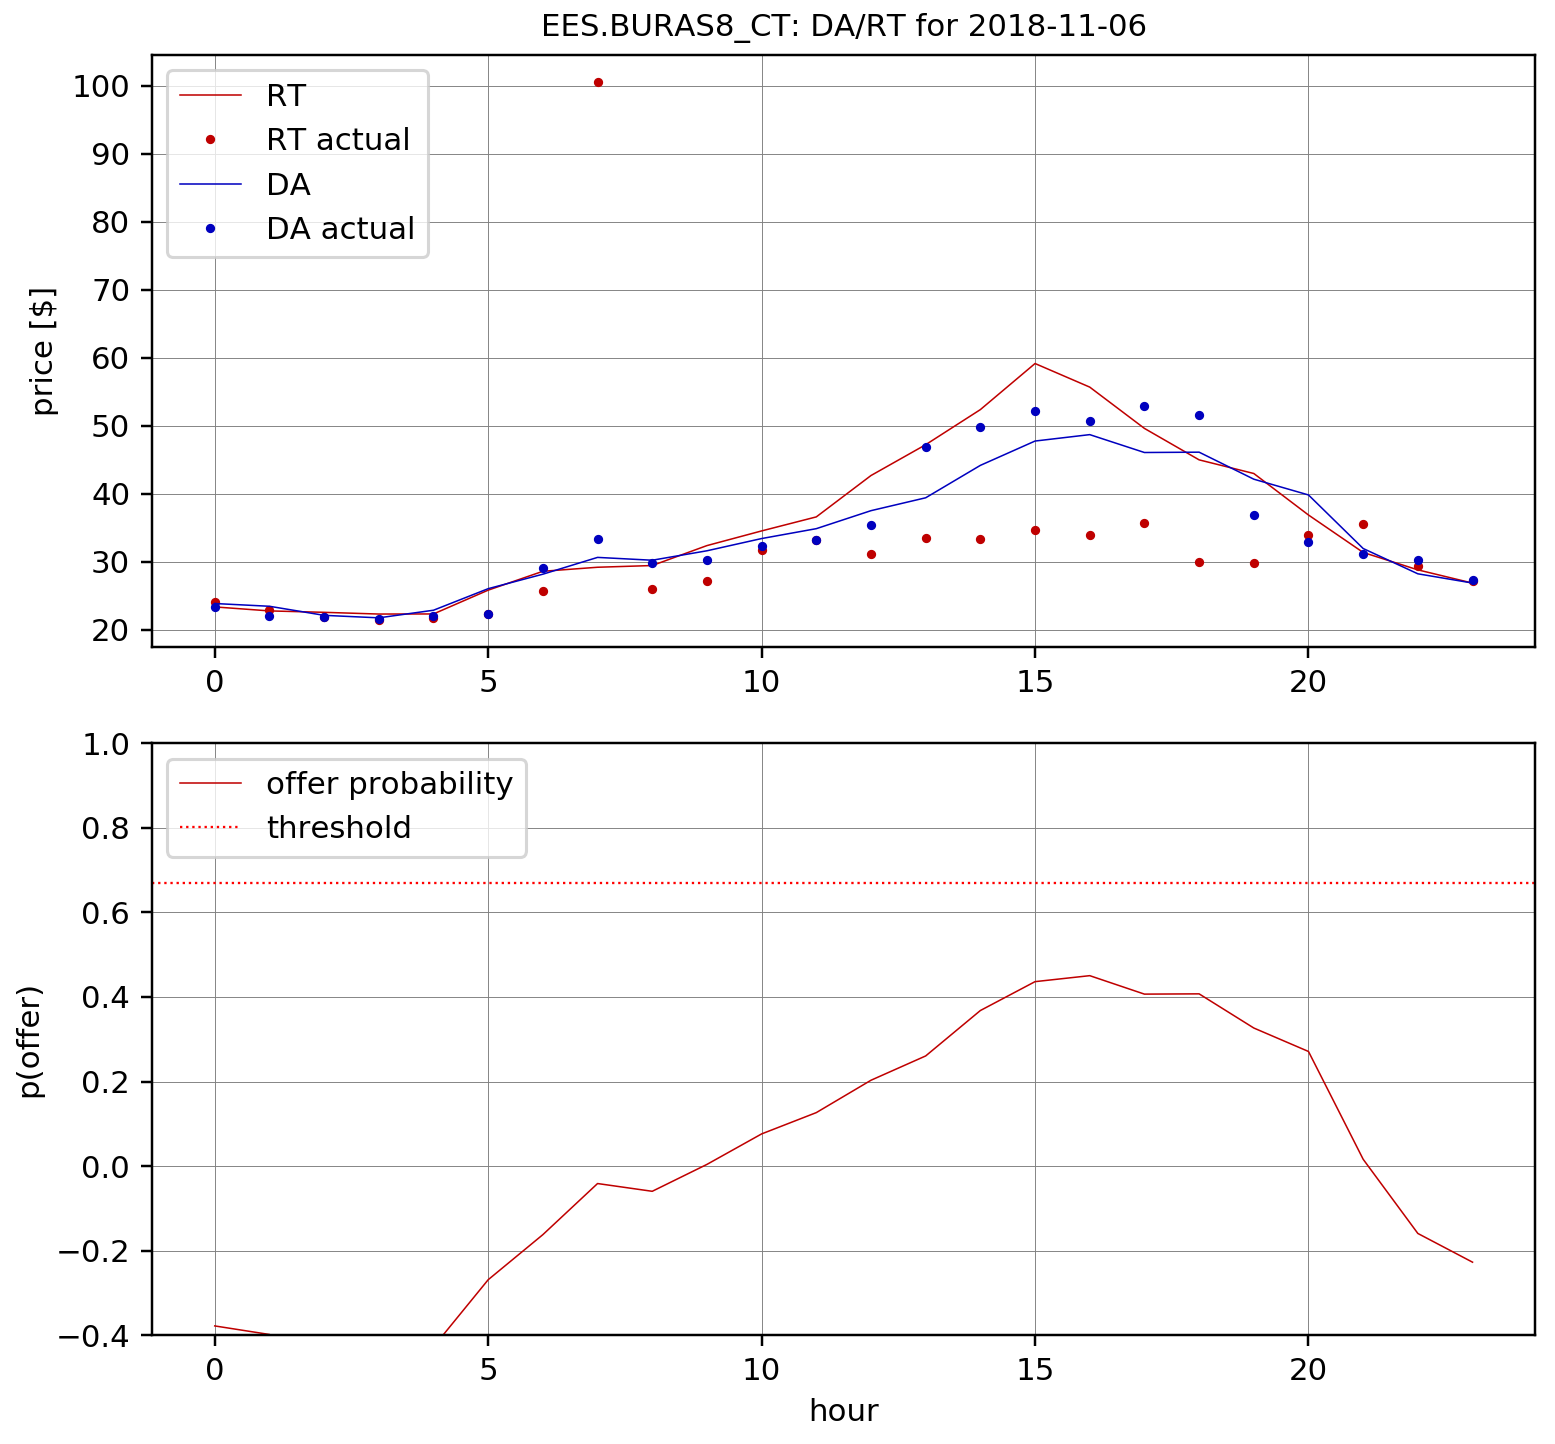

In [6]:
plt.figure(1, figsize=(7,6.5))

plt.subplot(211)
plt.title(node + ": DA/RT for " + date_str, fontsize=10)
plt.plot(node_data.rt_pred, '-', color=(0.75,0,0), linewidth=0.5, alpha=1, label='RT')
if has_actual: plt.plot(node_data.rt_actual, '.', color=(0.75,0,0), markersize=4, alpha=1, label='RT actual')
plt.plot(node_data.da_pred, '-', color=(0,0,0.75), linewidth=0.5, alpha=1, label='DA')
if has_actual: plt.plot(node_data.da_actual, '.', color=(0,0,0.75), markersize=4, alpha=1, label='DA actual')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.ylabel('price [$]')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(node_data.probability, '-', color=(0.75,0,0), linewidth=0.5, alpha=1, label='offer probability')
plt.axhline(threshold, color='red', linestyle='dotted', linewidth=0.75, label='threshold')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.ylim(-0.4,1)
plt.xlabel('hour')
plt.ylabel('p(offer)')
plt.legend(loc='upper left')

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()

### Display all nodes

<IPython.core.display.Javascript object>


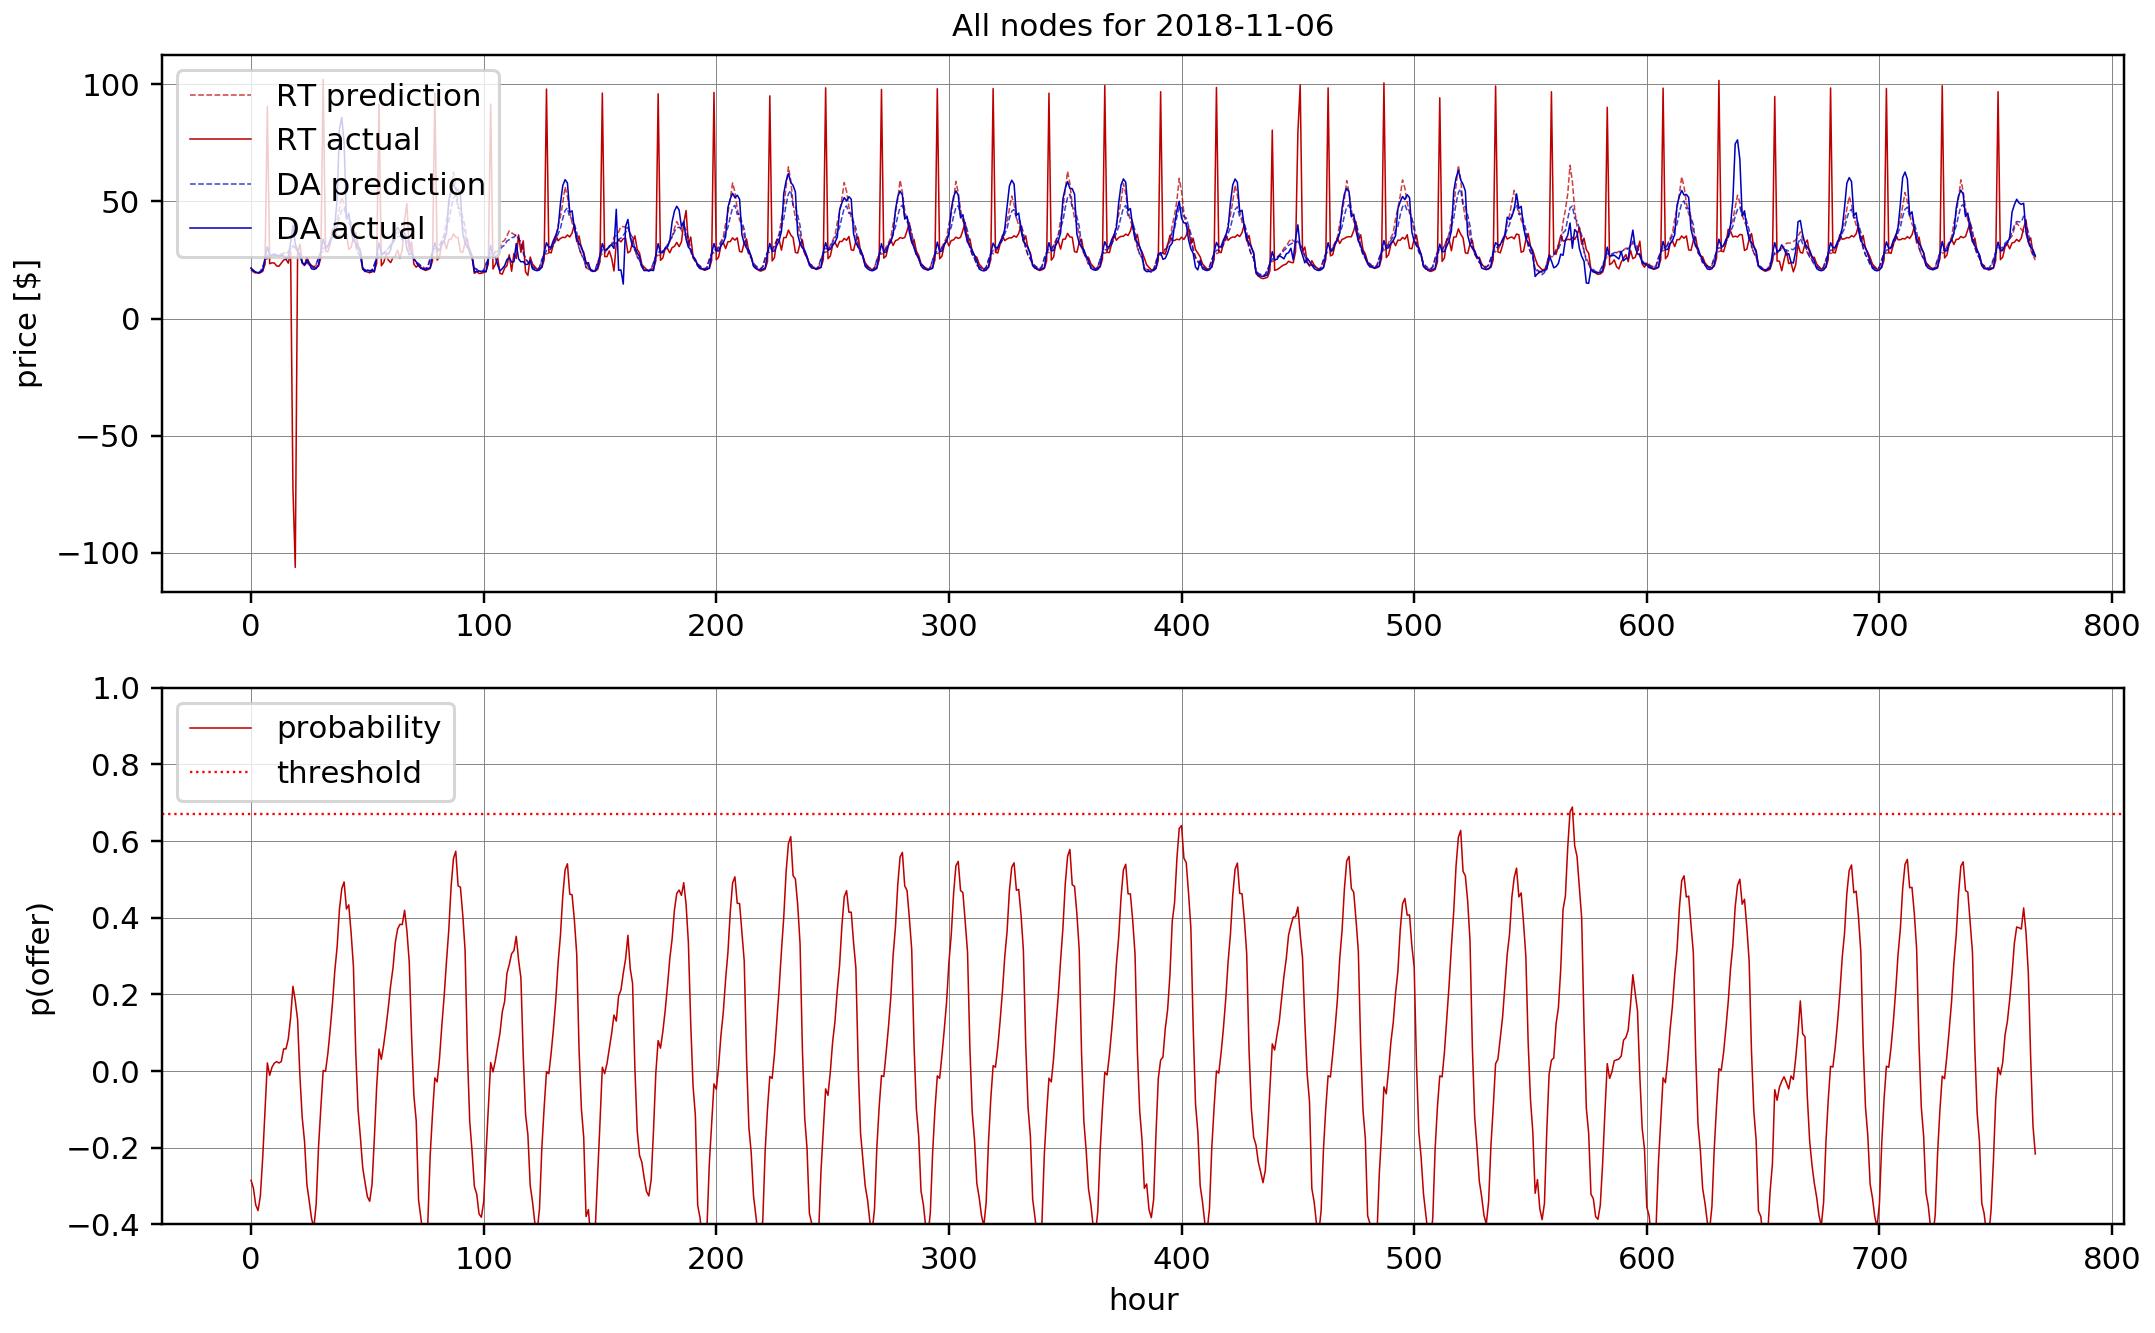

In [7]:
plt.figure(2, figsize=(9.7,6))

plt.subplot(211)
plt.title("All nodes for " + date_str, fontsize=10)
plt.plot(df.rt_pred, '--', color=(0.75,0,0), linewidth=0.5, alpha=0.75, label='RT prediction')
if has_actual: plt.plot(df.rt_actual, '-', color=(0.75,0,0), linewidth=0.5, alpha=1, label='RT actual')
plt.plot(df.da_pred, '--', color=(0,0,0.75), linewidth=0.5, alpha=0.75, label='DA prediction')
if has_actual: plt.plot(df.da_actual, '-', color=(0,0,0.75), linewidth=0.5, alpha=1, label='DA actual')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.ylabel('price [$]')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(df.probability, '-', color=(0.75,0,0), linewidth=0.5, alpha=1, label='probability')
plt.axhline(threshold, color='red', linestyle='dotted', linewidth=0.75, label='threshold')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.ylim(-0.4,1)
plt.xlabel('hour')
plt.ylabel('p(offer)')
plt.legend(loc='upper left')

plt.tight_layout(pad=0.4, w_pad=0.75, h_pad=1.0)
plt.show()